## **Overview**
**we will explore how to develop a suite of different types of LSTM models for time series forecasting.**

* ### **Univariate LSTM Models**

1. Data Preparation
2. Vanilla LSTM
3. Stacked LSTM
4. Bidirectional LSTM
5. CNN LSTM
6. ConvLSTM


* ### **Multivariate LSTM Models**

* ### **Multi-Step LSTM Models**

* ### **Multivariate Multi-Step LSTM Models**



In [1]:
import matplotlib
import warnings
# 忽略警告
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score as r2

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
# from scikeras.wrappers import KerasRegressor # 回归神经网络
from numpy import array
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Dense
from keras.layers import Bidirectional
# univariate bidirectional lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from tensorflow.python.keras.layers import CuDNNLSTM
from keras.layers import Bidirectional
import keras.backend as K
import os
import glob
import tensorflow as tf
from tensorflow.python.keras.layers import Activation
from keras import optimizers
from pygame import mixer
import time
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

pygame 2.5.1 (SDL 2.28.2, Python 3.11.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def read_someone_day_file(day):
    IMF = []
    xlsx_file = '../../Data/CEEMDAN/58606_2/'+day+'/'
    xlsx_path = glob.glob(os.path.join(xlsx_file,'*.xlsx'))

    data_col_len = pd.read_excel('../../Data/CEEMDAN/58606_2/'+day+'/CEEMDAN_58606 Station_g.xlsx',header=None)

    for imf_len in range(len(data_col_len.columns)):
        for file in xlsx_path:
             print(file)
             # print(os.path.basename(file))
             imfs = pd.read_excel(file,header=None)
             imfn = imfs.iloc[:,imf_len]
             imfn.to_numpy()
             IMF.append(imfn )
        print(imf_len,"-------------------")
    return IMF

In [3]:
def Result_Ana(Model, feature_num,testX,testY,scaler):
    print('Result_Ana_Function:',testX.shape)
    y_pred = Model.predict(testX)
    y_pred = np.array(y_pred).reshape(-1, 1)
    # 将一个数组prediction在最后一个轴上（即axis=-1）进行复制，重复8次，并将结果存储在prediction_copies_array数组中
    prediction_copies_array = np.repeat(y_pred, feature_num,axis=-1)
    prediction_copies_array
    print('-----------prediction copy Shape：',prediction_copies_array.shape,'------------------')
    # Multi Var prediction
    pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(y_pred), feature_num)))[:,feature_num-1] #进行逆变换但是，只需要最后一列
    # Single prediction
    # pred = scaler.inverse_transform(y_pred) #进行逆变换但是，只需要最后一列

    # print(pred)
    print('testY of shape :',testY.shape)
    y_true = np.array(testY).reshape(-1, 1)
    original_copies_array = np.repeat(testY, feature_num, axis=-1)
    print('IMF_True:',scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), feature_num))))
    y_true = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), feature_num)))[:, feature_num-1]

    print('feature_num-1_ETO_true:',y_true)

    # Single true value
    # y_true = scaler.inverse_transform(np.array(testY).reshape(-1,1))

    # y_true
    # pred

    print(pred)
    plt.plot(y_true, color='red', label='Real Value')
    plt.plot(pred, color='blue', label='Pred Value')
    plt.title('Prediction ETO (mm)')
    plt.xlabel('Time (day)')
    plt.ylabel('ETO (mm)')
    plt.legend()
    plt.show()


    print('MSE:',mse(y_true,pred))
    print('MAE:',mae(y_true,pred))
    print('R²:',r2(y_true,pred))
    print('RMSE:',np.sqrt(mse(y_true,pred)))
    print('pred_finally:',pred)

    return y_true,pred

In [4]:
def ceemdan_lstm(day):
    mixer.init()
    mixer.music.load('../../Resources/ExecuteTipAudio.mp3')

    reshape1 = 0
    IMF = read_someone_day_file(day)

    imf_choose = 0
    finally_rsult = []
    finally_y_true = []

    for imf_run in range(int(len(IMF) / 7)):
        ALL_Factor_IMF = IMF[imf_choose:imf_choose+7][:]
        imf_choose = imf_choose + 7

        print('--------------------------',imf_run,'--------------------------')
        ALL_Factor_IMF = np.array(ALL_Factor_IMF)
        IMF_Input = np.transpose(ALL_Factor_IMF)

        df_IMF = pd.DataFrame(IMF_Input)
        df_IMF.columns = ['one','two','three','four','five','six', 'seven']

        print(df_IMF)

        scaler = MinMaxScaler(feature_range=(0, 1))
        df = scaler.fit_transform(df_IMF)

        sacler_data_len = len(df_IMF.columns)

        #数据集划分
        test_split = round(len(df) * 0.20)
        print(test_split)
        def splitData(var, per_test):
            num_test = int(len(var) * per_test)
            train_size = int(len(var) - num_test)
            train_data = var[0:train_size]
            test_data = var[train_size:train_size + num_test]
            return train_data, test_data


        df_training, df_testing = splitData(df, 0.2)
        print('df_training.shape:',df_training.shape)
        print('df_testing.shape:',df_testing.shape)

        def createXY(data,n_past,n_steps_out):
            dataX,dataY = list(),list()

            for i in range(len(data)):
                ## such as: len(data) = 19624
                end_ix = i + n_past ## 0+3=3,1+3=4,...,19618+3=19621
                out_end_ix = end_ix + n_steps_out ## 3+3=6,4+3=7,...,19621+3=19624
                # print('out_end_ix:',out_end_ix)
                '''
                加入此处判断，使得最终的dataX和dataY中每行的数组长度一致，进而可以转换为array(数组),如若不加以限制，
                则导致最后几次循环由于i是在len(data)范围内的，
                但是由于out_end_ix=end_ix + n_steps_out,最终会超出data的数据范围，而导致其无法获取到数据,
                加入dataY之后，最后几行的数据长度是和前面的数据长度不一致，最终导致无法进行array转换
                '''
                if out_end_ix > len(data): ## 6 < len(data),7<len(data),...,19623+3=19626>len(data)=19624
                    # print("------------out_end_ix of end",out_end_ix,'---------------')
                    break

                dataX.append(data[i:end_ix,0:data.shape[1]]) ## 0:3,0:7;1:4,0:7
                dataY.append(data[end_ix:out_end_ix,data.shape[1]-1]) ##3:6,6;4:7,6
            return np.array(dataX), np.array(dataY)

        n_past=1
        n_steps_out=1

        trainX, trainY = createXY(df_training, n_past, n_steps_out)
        testX, testY = createXY(df_testing, n_past, n_steps_out)

        reshape1 = testY.shape[0]

        print('trainX.Shape:----', trainX.shape)
        print('trainY.shape:----', trainY.shape)
        print('testX.shape:----', testX.shape)
        print('testY.shape:----', testY.shape)

        # trainY = trainY.reshape(-1)
        # testY = testY.reshape(-1)
        # print('trainY Shape 2 ---', trainY.shape)
        # print('testY Shape 2 ---', testY.shape)
        # trainX = np.expand_dims(trainX,axis=1)
        # testX = np.expand_dims(testX,axis=1)
        # print('expand_dims_trainX of shape',trainX.shape)
        # print('expand_dims_testX of shape',testX.shape)

        print('----------------------------',imf_run,'------------------------------')

        def BiLSTM(optimizer='Adam', batch_size=32, epochs=40):
            model = Sequential()
            model.add(Bidirectional(LSTM(150, activation='relu', input_shape=(n_past, sacler_data_len))))
            # model.add(LSTM(100,activation='relu'))
            #model.add(CuDNNLSTM(200, return_sequences=True, input_shape=(None, sacler_data_len)))

            # model.add(LSTM(50, activation='relu'))
            model.add(Dropout(0.1))
            # model.add(LSTM(50, activation='relu'))
            # model.add(Dropout(0.1))

            # optimizer = Adam()  # 设置为您希望的学习率
            # model.add(Dense(1))
            ## Full connection layer: This is output shape(e.g. 3 Dimension that trainY.shape[1] = 3 represent for each output is 3 number)
            model.add(Dense(1))
            # model.add(Activation('linear'))

            model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
            return model


        BiLSTM_Model = KerasRegressor(BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))
        # N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1)

        from sklearn.model_selection import GridSearchCV

        # 定义超参数搜索范围
        param_grid = {
            'optimizer': ['Adam'],
            'batch_size': [32, 64, 128],
            'epochs': [20, 30]
            # 'batch_size': [64],
            # 'epochs': [40]
        }

        # 执行网格搜索
        grid = GridSearchCV(estimator=BiLSTM_Model, param_grid=param_grid, cv=2)
        grid_result = grid.fit(trainX, trainY)

        best_params = grid_result.best_params_

        best_params
        print('prediction' , 'one' ,'day best_params:', best_params)

        best_model = grid_result.best_estimator_

        y_trues,prediction_result = Result_Ana(best_model, sacler_data_len,testX,testY,scaler)

        print('prediction_result:',prediction_result)
        finally_rsult.append(prediction_result)
        print('lstm_y_turs:',y_trues)
        finally_y_true.append(y_trues)

        mixer.music.play()
        time.sleep(1)
        mixer.music.stop()
    return reshape1,finally_y_true,finally_rsult,day

In [5]:
def plot_save_true_prediction(reshape1,finally_y_true,finally_rsult,day):
    # WL(Water Level(m)) For IMF1-IMF13-R True Value
    finally_y_true
    finally_ytrue_r = np.array(finally_y_true)
    finally_ytrue_r
    reshape2 = len(finally_ytrue_r)
    reshape2
    finally_column_names = []

    for i in range(1, reshape2 + 1):
        if i < (reshape2):
            finally_column_names.append("IMF" + str(i))
        else:
            finally_column_names.append("Residual")
    finally_column_names
    ALL_Factor_ReIMFS_Yture_Result = np.transpose(finally_ytrue_r)
    reshape1
    ALL_Factor_ReIMFS_Yture_Result = ALL_Factor_ReIMFS_Yture_Result.reshape(reshape1, reshape2)
    all_factor_ceemdan_true = pd.DataFrame(ALL_Factor_ReIMFS_Yture_Result, columns=finally_column_names)
    all_factor_ceemdan_true
    sums = all_factor_ceemdan_true.iloc[:, :].sum(axis=1)

    # 将求和结果添加到DataFrame中作为新的一列
    all_factor_ceemdan_true["True"] = sums
    # 保存为CSV文件
    true_file_path = "Result/CEEMDAN/"+day+"_day_CEEMDAN_IMF" + str(reshape2 - 1) + "-CNN_true.csv"

    all_factor_ceemdan_true.to_csv(true_file_path,
                                   index=False)
    # WL(Water Level(m)) IMF1-IMF13-R Prediction Value
    finally_rsult
    finally_r = np.array(finally_rsult)
    finally_r
    ALL_Factor_ReIMFS_Result = np.transpose(finally_r)
    ALL_Factor_ReIMFS_Result = ALL_Factor_ReIMFS_Result.reshape(reshape1, reshape2)
    finally_column_names
    all_factor_ceemdan_prediction = pd.DataFrame(ALL_Factor_ReIMFS_Result, columns=finally_column_names)
    all_factor_ceemdan_prediction
    sums = all_factor_ceemdan_prediction.iloc[:, :].sum(axis=1)

    # 将求和结果添加到DataFrame中作为新的一列
    all_factor_ceemdan_prediction["Pred"] = sums
    prediction_file_path = "Result/CEEMDAN/"+day+"_day_CEEMDAN_IMF" + str(reshape2 - 1) + "-CNN_prediction.csv"
    # 保存为CSV文件
    all_factor_ceemdan_prediction.to_csv(prediction_file_path, index=False)
    ### 验证最终结果
    df = pd.read_csv(prediction_file_path)
    df = df[['Pred']]
    df

    origin = pd.read_csv(true_file_path)
    origin = origin[['True']]
    # y_true = origin.iloc[:,len(origin.columns)-1]
    y_true = origin
    y_true
    pred = df
    y_true
    pred
    plt.plot(y_true, color='red', label='Real Value')
    plt.plot(pred, color='blue', label='Pred Value')
    plt.title('Prediction ET0 ')
    plt.xlabel('Time')
    plt.ylabel('Detail Value')
    plt.legend()
    # plt.savefig('../Images/SW_IN_F_Train_'+'n_past='+'{}'.format((trainX[1].shape)[0])+'_epochs={}'.format((grid_search.best_params_)['epochs'])+'.png',dpi=600)
    plt.show()
    # y_true_data = pd.DataFrame(y)
    # y_true_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_True' + '.csv',
    #               index=False)
    # pred_data = pd.DataFrame(pred)
    # pred_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_Pre' + '.csv',
    #              index=False)
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae
    from sklearn.metrics import r2_score as r2

    print('MSE:', mse(y_true, pred))
    print('MAE:', mae(y_true, pred))
    print('R²:', r2(y_true, pred))
    print('RMSE:', np.sqrt(mse(y_true, pred)))
    print('pred_finally:', pred)

------------------ FifteenDay --------------------
This is  FifteenDay -th for prediction et0
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_a.xlsx
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_b.xlsx
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_c.xlsx
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_d.xlsx
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_e.xlsx
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_f.xlsx
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_g.xlsx
0 -------------------
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_a.xlsx
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_b.xlsx
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_c.xlsx
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_d.xlsx
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_e.xlsx
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_f.xlsx
../../Data/CE

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_42156\3250511775.py:112: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  BiLSTM_Model = KerasRegressor(BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


21/21 [==============================] - 2s 14ms/step - loss: 0.1856 - mse: 0.1856 - val_loss: 0.0724 - val_mse: 0.0724
Epoch 2/20
21/21 [==============================] - 0s 3ms/step - loss: 0.0388 - mse: 0.0388 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 3/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0273 - val_mse: 0.0273
Epoch 4/20
21/21 [==============================] - 0s 3ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0253 - val_mse: 0.0253
Epoch 5/20
21/21 [==============================] - 0s 3ms/step - loss: 0.0241 - mse: 0.0241 - val_loss: 0.0237 - val_mse: 0.0237
Epoch 6/20
21/21 [==============================] - 0s 3ms/step - loss: 0.0229 - mse: 0.0229 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 7/20
21/21 [==============================] - 0s 3ms/step - loss: 0.0224 - mse: 0.0224 - val_loss: 0.0212 - val_mse: 0.0212
Epoch 8/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0211 - mse: 0.0211 - val_l

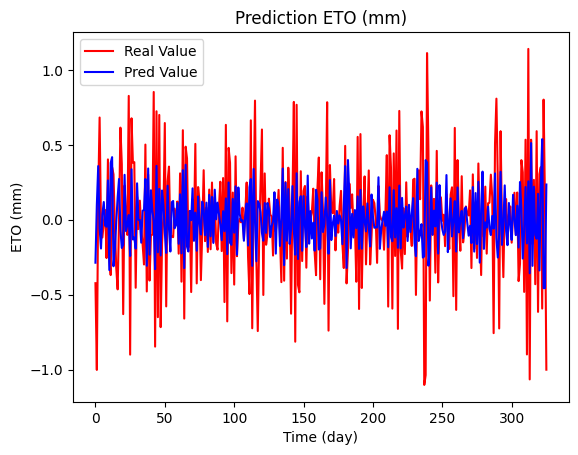

MSE: 0.1351000710848919
MAE: 0.2698564131016394
R²: 0.14862376645753417
RMSE: 0.3675596156882471
pred_finally: [-2.86451399e-01  9.82312337e-02  3.58309686e-01 -5.52999824e-02
 -1.91860437e-01  3.69272754e-02  1.18702188e-01 -3.81297357e-02
 -4.64838743e-02  2.62590915e-01 -3.35414588e-01  3.80041778e-01
  4.18026060e-01 -3.10192347e-01 -1.96487427e-01 -1.61319636e-02
  1.49151996e-01  2.72246122e-01 -6.88103586e-02 -1.88231274e-01
 -1.65899798e-01  3.00251216e-01 -7.51393214e-02 -3.36862393e-02
  3.16128321e-02 -2.41706625e-01  3.37188870e-01 -1.31374866e-01
 -1.17756531e-01 -1.92595452e-01  2.43443057e-01 -5.14858286e-04
 -1.31147390e-03 -1.52798578e-01  6.09131455e-02  6.41119927e-02
  2.72217572e-01 -3.07102233e-01  3.42538923e-01 -2.32573166e-01
  1.97088629e-01  6.41713515e-02 -6.73826644e-03 -3.29454690e-01
  3.59938532e-01 -2.16948748e-01  2.05833510e-01 -2.38138720e-01
  1.95568696e-01  1.01081498e-01 -8.37883651e-02 -2.21052617e-01
  2.27640301e-01 -5.73345348e-02 -2.11683348

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_42156\3250511775.py:112: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  BiLSTM_Model = KerasRegressor(BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


21/21 [==============================] - 2s 14ms/step - loss: 0.1345 - mse: 0.1345 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 2/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 3/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 4/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 5/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 6/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 7/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 8/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0035 - mse: 0.0035 - val_l

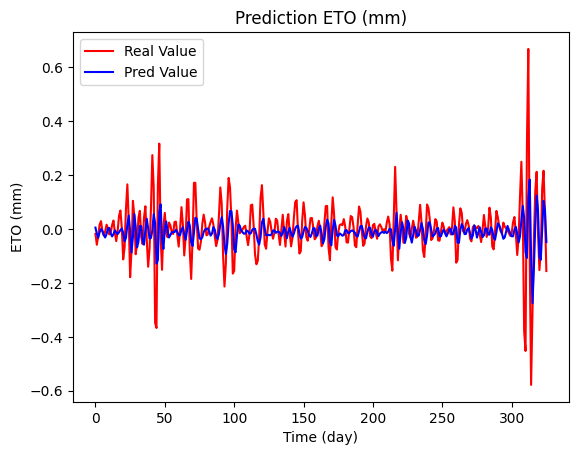

MSE: 0.008691259265066965
MAE: 0.0599434334467675
R²: 0.14095676840841653
RMSE: 0.09322692349888505
pred_finally: [ 5.26581798e-03 -1.75381321e-02 -3.23851481e-02 -1.19416947e-02
 -2.73627025e-04 -6.13745768e-03 -2.19684038e-02 -3.14886756e-02
 -1.86791848e-02  1.88026100e-03  4.08036774e-03 -1.65358484e-02
 -2.75618322e-02 -1.86182912e-02 -5.03497059e-03 -1.23056481e-02
 -1.85642317e-02 -1.22312671e-02 -3.94823682e-03  2.06234935e-03
 -1.38243260e-02 -4.60146479e-02 -3.30839269e-02  1.63373519e-02
  4.97720912e-02 -9.59375501e-03 -8.71511474e-02 -3.04704905e-02
  5.50732724e-02  8.45427718e-03 -6.79939836e-02 -4.75397520e-02
  1.13112172e-02  1.05987657e-02 -4.30792756e-02 -5.81271425e-02
 -3.53197125e-03  3.82345766e-02  2.31658947e-03 -3.52168605e-02
 -3.34868170e-02 -6.49067434e-03  5.51214218e-02  2.25735698e-02
 -1.28395617e-01 -1.14842430e-01  6.33035451e-02  9.14568231e-02
 -4.10185307e-02 -7.38448799e-02  4.41165263e-04  2.76850462e-02
 -6.93447003e-03 -3.15924063e-02 -2.25848

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_42156\3250511775.py:112: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  BiLSTM_Model = KerasRegressor(BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


21/21 [==============================] - 2s 13ms/step - loss: 0.0900 - mse: 0.0900 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 2/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0203 - val_mse: 0.0203
Epoch 3/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 4/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0174 - val_mse: 0.0174
Epoch 5/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0169 - val_mse: 0.0169
Epoch 6/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 7/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 8/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0095 - mse: 0.0095 - val_l

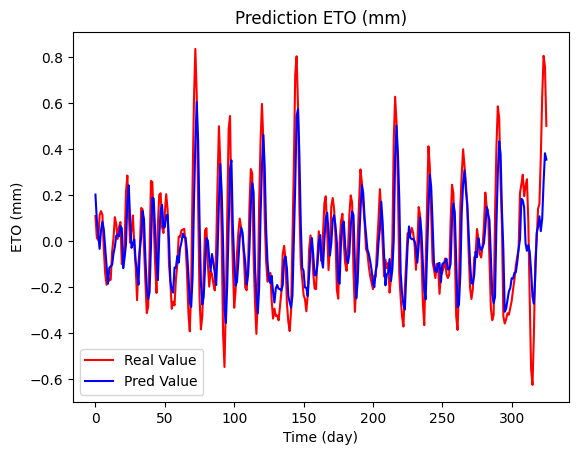

MSE: 0.023970835127585115
MAE: 0.11581035442904526
R²: 0.6079613996959548
RMSE: 0.15482517601341558
pred_finally: [ 0.2012193   0.08952316  0.02848058 -0.03464475  0.04499805  0.08349047
  0.05113725 -0.03013919 -0.11102832 -0.18637763 -0.11810406 -0.11016976
 -0.10478605 -0.05614054 -0.02622083  0.02277351  0.02762677  0.01941788
  0.06523399  0.05480788 -0.11873481 -0.07334904 -0.01532455  0.17109731
  0.24122126  0.0946404  -0.03052809 -0.01328313  0.00625195 -0.0911523
 -0.12451005 -0.19057308 -0.03977585  0.01842834  0.12948608  0.09424013
 -0.07770431 -0.20340213 -0.25284207 -0.22403316 -0.0275452   0.18829204
  0.18343395  0.04404248 -0.07639864 -0.17069292  0.01788511  0.13169226
  0.15675537  0.05759966  0.0601867   0.11127231  0.11323424  0.00224523
 -0.17459287 -0.21239798 -0.22510721 -0.11586486 -0.11546896 -0.06610657
 -0.09447575 -0.0318649  -0.00645456  0.03138041  0.01527289  0.01468823
 -0.0479309  -0.14554356 -0.26791418 -0.28719968 -0.15963838  0.16172877
  0.4213073

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_42156\3250511775.py:112: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  BiLSTM_Model = KerasRegressor(BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


21/21 [==============================] - 2s 16ms/step - loss: 0.1334 - mse: 0.1334 - val_loss: 0.0382 - val_mse: 0.0382
Epoch 2/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0233 - val_mse: 0.0233
Epoch 3/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0181 - mse: 0.0181 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 4/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 5/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 6/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 7/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 8/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0067 - mse: 0.0067 - val_l

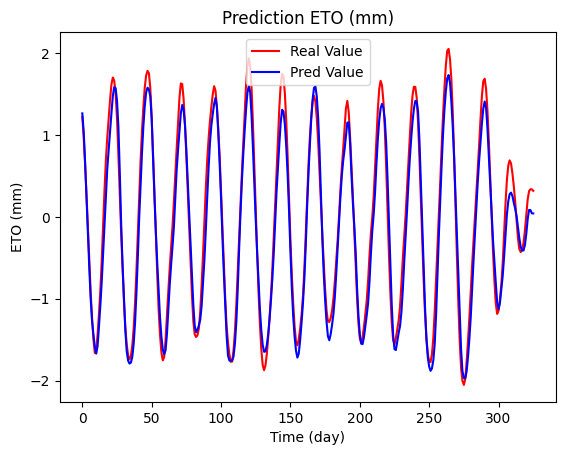

MSE: 0.049961734501281455
MAE: 0.19248842453674975
R²: 0.9611925208967069
RMSE: 0.22352121711658932
pred_finally: [ 1.2674122   1.0390217   0.67240006  0.24235277 -0.17403293 -0.6131436
 -0.9955479  -1.2664807  -1.436695   -1.5831666  -1.6710888  -1.579705
 -1.3392893  -1.0778648  -0.785741   -0.43768662 -0.10254236  0.2655742
  0.5966642   0.8241955   1.0339763   1.272244    1.4820558   1.588133
  1.5775987   1.4220986   1.103975    0.545266   -0.08152053 -0.57952136
 -0.99674314 -1.3875366  -1.6423222  -1.7553587  -1.7927758  -1.780813
 -1.712364   -1.5519298  -1.2934942  -0.9304071  -0.49390802 -0.00854411
  0.39448503  0.7838075   1.1094075   1.356266    1.5235788   1.5816827
  1.5600528   1.4759367   1.1997006   0.72408754  0.23815876 -0.18632258
 -0.56196856 -0.8986074  -1.229215   -1.4632418  -1.6214213  -1.67822
 -1.6310372  -1.4297609  -1.1188103  -0.8301988  -0.5845473  -0.36355323
 -0.12183338  0.22354354  0.57591885  0.82383525  1.0437788   1.2669493
  1.3704351   1.3109802

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_42156\3250511775.py:112: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  BiLSTM_Model = KerasRegressor(BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


21/21 [==============================] - 2s 16ms/step - loss: 0.0963 - mse: 0.0963 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 2/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 3/20
21/21 [==============================] - 0s 5ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 4/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 5/20
21/21 [==============================] - 0s 5ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 6/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 7/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 8/20
21/21 [==============================] - 0s 6ms/step - loss: 0.0059 - mse: 0.0059 - val_l

In [6]:
%%time
if __name__ == '__main__':
    days = ['FifteenDay']
    for day in days:
       print('------------------',day ,'--------------------')
       print('This is ',day,'-th for prediction et0')
       reshape1,finally_y_true,finally_rsult,day = ceemdan_lstm(day)
       print('This is ',day,'-th for prediction et0')
       print('------------------',day,'---------------------')
       plot_save_true_prediction(reshape1,finally_y_true,finally_rsult,day)